In [18]:
import hdphmm
import mdtraj as md

In [33]:
traj = '5ms_nojump.xtc'
gro = 'em.gro'
residue = 'MET'
difference = True  # take first order difference of solute trajectories
observation_model='AR'  # assume an autoregressive model
order = 1  # autoregressive order
max_states = 20
traj_no = 2
radial = True  # replace xy coordinates with radial distance from pore centers
first_frame = 7000  # frame after which simulation is equilibrated

# You can define a dictionary with some spline paramters
spline_params = {'npts_spline': 10, 'save': True, 'savename': 'spline_hdphmm.pl'}

com = 'comr.pl'  # center of mass trajectories. If it exists, we can skip loading the MD trajectory and just load this

if com is not None:
    
    data = com
    load_com = True

else:
    
    data = traj
    load_com = False

ihmm = hdphmm.InfiniteHMM(data, radial=radial, traj_no=traj_no, gro=gro, load_com=load_com, res=residue, 
                          difference=True, observation_model=observation_model, order=order, 
                          max_states=max_states, first_frame=first_frame, spline_params=spline_params)


Loaded center-of-mass coordinates
Took first order difference of center of mass trajectories
Fitting 1 2 dimensional trajectories assuming an autoregressive order of 1


(4806, 1, 2)


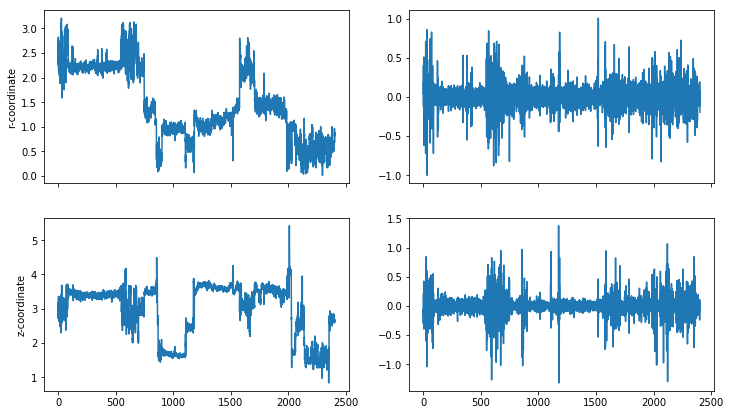

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

print(ihmm.trajectories.shape)

nT = ihmm.trajectories.shape[0]
time = np.linspace(0, nT*ihmm.dt / 1000, nT)
ylabels = ['r-coordinate', 'z-coordinate']

for i in range(2):
    traj = ihmm.com[2:, 0, i]
    ax[i, 0].plot(time, traj)
    ax[i, 1].plot(time, ihmm.trajectories[:, 0, i])
    ax[i, 0].set_ylabel(ylabels[i])

#plt.xlabel('Time ($\mu$s)')
plt.show()

In [35]:
ihmm.inference(100)

100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


Found 3 unique states

Estimated Transition Matrix:

[[0.9541 0.0072 0.0387]
 [0.0636 0.7479 0.1886]
 [0.1032 0.0689 0.828 ]]


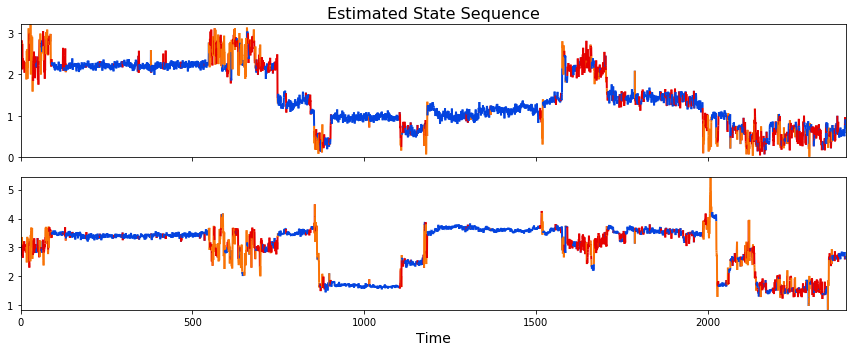

In [36]:
ihmm.summarize_results()